In [3]:
import pandas as pd
import numpy as np

import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore")


In [6]:
questions_path = "../data/Questions.csv"
tags_path = "../data/Tags.csv"


questions_df = pd.read_csv(questions_path, encoding='ISO-8859-1')
tags_df = pd.read_csv(tags_path, encoding='ISO-8859-1')


print("Questions.csv")
display(questions_df.head())

print("\nTags.csv")
display(tags_df.head())


Questions.csv


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...



Tags.csv


,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [7]:
tags_grouped = tags_df.groupby("Id")["Tag"].apply(list).reset_index()

merged_df = pd.merge(questions_df, tags_grouped, left_on="Id", right_on="Id")

merged_df = merged_df[["Title", "Body", "Tag"]]
merged_df.columns = ["title", "body", "tags"]

merged_df.head()

,title,body,tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


In [8]:
from collections import Counter

all_tags = [tag for tags in merged_df["tags"] for tag in tags]
tag_counts = Counter(all_tags)


top_tags = [tag for tag, count in tag_counts.most_common(100)]

filtered_df = merged_df.copy()
filtered_df["tags"] = filtered_df["tags"].apply(lambda tag_list: [tag for tag in tag_list if tag in top_tags])


filtered_df = filtered_df[filtered_df["tags"].map(len) > 0]

filtered_df.reset_index(drop=True, inplace=True)
filtered_df.head()


,title,body,tags
0,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
1,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
2,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
3,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, class]"
4,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,"[.net, web-services]"


In [5]:
filtered_df.shape
filtered_df["tags"].explode().value_counts()


tags
javascript       124155
java             115212
c#               101186
php               98808
android           90659
                  ...  
google-chrome      4336
jsp                4312
symfony2           4228
python-3.x         4222
tsql               4158
Name: count, Length: 100, dtype: int64

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(filtered_df["tags"])

y.shape


(1057478, 100)

In [10]:
X = (filtered_df["title"] + " " + filtered_df["body"]).astype(str)
X.iloc[0]


"ASP.NET Site Maps <p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <strong>SiteMapPath</strong> controls, but I'll need a way for the users of my site to create and modify pages dynamically.</p>\n\n<p>I need to tie page viewing permissions into the standard <code>ASP.NET</code> membership system as well.</p>\n"

In [11]:
import re

def clean_text(text):
    text = re.sub(r'<[^>]+>', ' ', text)            
    text = re.sub(r'\s+', ' ', text)                
    text = re.sub(r'\n', ' ', text)                
    text = re.sub(r'[^\w\s#@/\\-]', '', text)       
    return text.strip().lower()

X_cleaned = X.apply(clean_text)
X_cleaned.iloc[0]


'aspnet site maps has anyone got experience creating sql-based aspnet site-map providers ive got the default xml file websitemap working properly with my menu and sitemappath controls but ill need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard aspnet membership system as well'

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50000)
X_tfidf = vectorizer.fit_transform(X_cleaned)

X_tfidf.shape


(1057478, 50000)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

X_train.shape, y_train.shape


((845982, 50000), (845982, 100))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)


,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


In [12]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))
undetected = np.where(y_pred.sum(axis=0) == 0)[0]
print("Tahmin edilemeyen etiket sayısı:", len(undetected))
[mlb.classes_[i] for i in undetected]
sample_idx = 10



                    precision    recall  f1-score   support

         .htaccess       0.88      0.71      0.79      1086
              .net       0.55      0.12      0.19      4760
              ajax       0.73      0.47      0.57      3120
         algorithm       0.75      0.36      0.49      1295
           android       0.97      0.85      0.90     18100
         angularjs       0.95      0.82      0.88      4044
            apache       0.71      0.37      0.48      1364
               api       0.38      0.08      0.13       973
            arrays       0.62      0.34      0.44      3980
           asp.net       0.80      0.50      0.61      5955
       asp.net-mvc       0.75      0.48      0.58      2812
              bash       0.81      0.55      0.66      1602
                 c       0.80      0.49      0.61      4673
                c#       0.76      0.50      0.60     20188
               c++       0.84      0.56      0.67      9547
             class       0.28      0.04

In [ ]:
import joblib


joblib.dump(model, "../models/tfidf_model.pkl")
joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")
joblib.dump(mlb, "../models/multilabel_binarizer.pkl")


['../models/multilabel_binarizer.pkl']

In [16]:
import joblib


mlb = joblib.load('../models/multilabel_binarizer.pkl')
model = joblib.load('../models/tfidf_model.pkl')


GRAPHS FOR VISUALIZATION

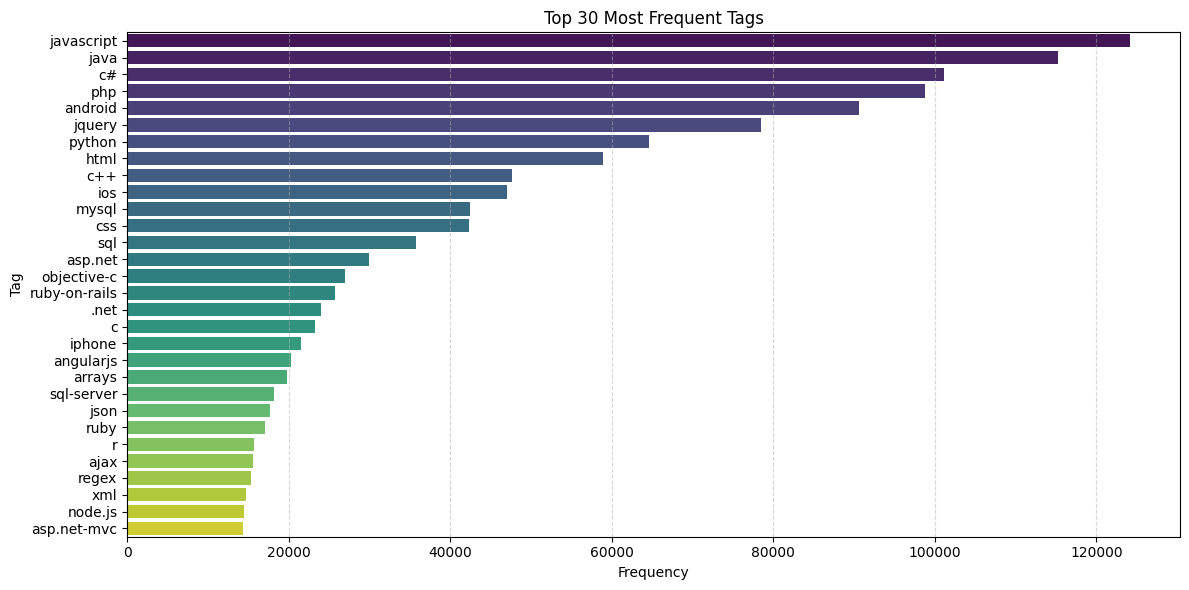

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


all_tags = [tag for tag_list in filtered_df["tags"] for tag in tag_list]
tag_counts = Counter(all_tags)


top_tags = tag_counts.most_common(30)
tags, counts = zip(*top_tags)


plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(tags), palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Tag")
plt.title("Top 30 Most Frequent Tags")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


TAG-BASED GRAPHS FOR PRECISION RECALL F1

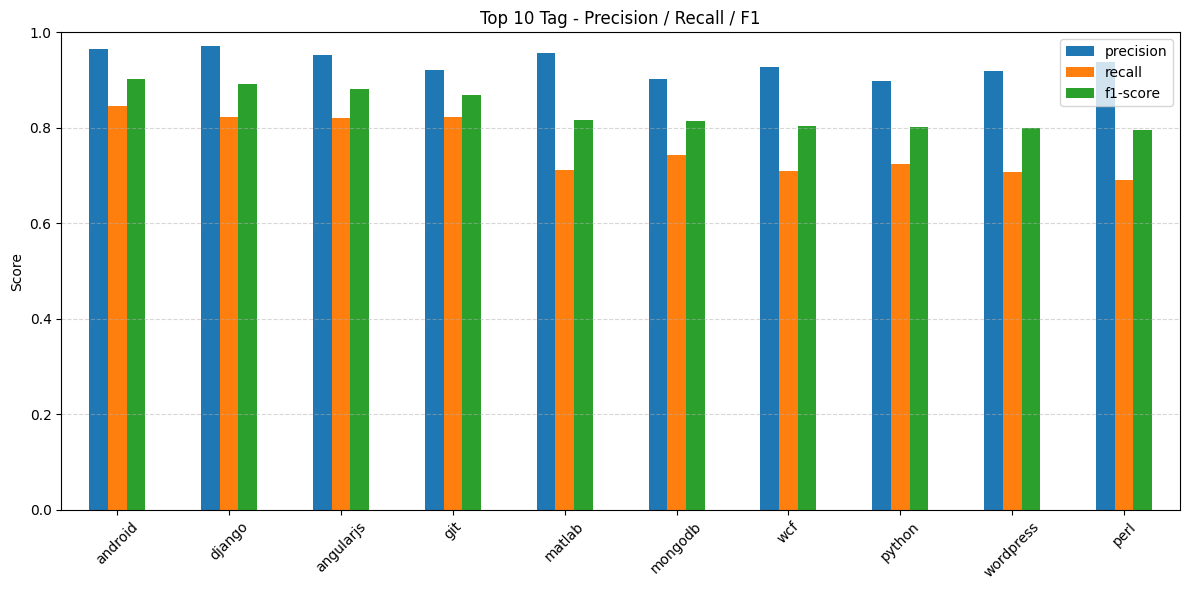

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

y_pred = model.predict(X_test)


report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)


df_report = pd.DataFrame(report).T
df_tags = df_report.iloc[:-3][["precision", "recall", "f1-score"]]  # support vs hariç


df_top10 = df_tags.sort_values("f1-score", ascending=False).head(10)


df_top10.plot(kind="bar", figsize=(12, 6))
plt.title("Top 10 Tag - Precision / Recall / F1")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


OVERALL PERFORMANCE METRICS

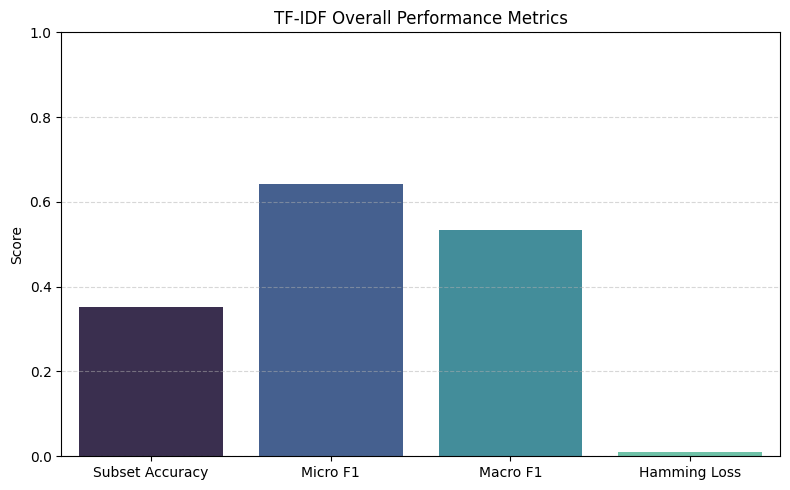

In [ ]:
from sklearn.metrics import f1_score, hamming_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


subset_acc = np.mean(np.all(y_test == y_pred, axis=1))


micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")
hloss = hamming_loss(y_test, y_pred)


metrics = {
    "Subset Accuracy": subset_acc,
    "Micro F1": micro_f1,
    "Macro F1": macro_f1,
    "Hamming Loss": hloss
}


plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
plt.title("TF-IDF Overall Performance Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [21]:
sample_text = ["How can I dynmacially update HTML content using JavaScript and jQuery on a button click?"]
#How to connect a Java application to a MySQL database and perform basic SQL queries?
#Why does my Android app crash when accessing a JSON API from a PHP backend?

sample_tfidf = vectorizer.transform(sample_text)


pred_tfidf = model.predict(sample_tfidf)


predicted_tags_tfidf = mlb.inverse_transform(pred_tfidf)[0]

print("TF-IDF Prediction:", predicted_tags_tfidf)


TF-IDF Prediction: ('html', 'javascript', 'jquery')
